# CNN Model Training


1.   Lenet Model Architecture : Requires 32*32 pixel images with 1 input channel
2.   Alexnet Model Architecture: Accepts 256 * 256 pixel images with 3 channels

## Importing Required Libraries

In [51]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from importlib import reload
import pickle
from sklearn.metrics import accuracy_score
from skorch.helper import predefined_split

In [52]:
def readPickleFile(path, file):
  opath = path+file
  data = None
  with open(opath, "rb") as file:
    data = pickle.load(file)
  return data

In [53]:
# custom dataset class. 
class MaskDataSet(Dataset):
  def __init__(self, data, label, transform=None, target_transform=None):
    super(Dataset, self).__init__()
    self.data = data
    self.label = label
    self.transform = transform
    self.target_transform = target_transform
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    img = self.data[index]
    if(self.transform):
      img = self.transform(img)
      
    label = self.label[index]
    if(self.target_transform):
      label = self.target_transform(label)
    return img, label


## Lenet 5 Architecutre
<img src="./lenet.jpeg" alt="drawing" width="800"/>

Photo Credit: https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

In [54]:
# lenet model architecture. 
class LenetModel(nn.Module):

  def __init__(self):
    super(LenetModel, self).__init__()

    self.conv1 = nn.Conv2d(1, out_channels=6, kernel_size=5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(16, 120, stride = 1, kernel_size = 5, padding = 0)
    self.liner1 = nn.Linear(120, 84)
    self.liner2 = nn.Linear(84, 10)
    self.relu = nn.ReLU()
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    # following the architecture given for this model
    output = self.conv1(x)
    output = self.relu(output)
    output = self.avgpool(output)
    output = self.conv2(output)
    output = self.relu(output)
    output = self.avgpool(output)
    output = self.conv3(output)
    output = self.relu(output)

    # flattening layer in the model to pass to the linear fc network .
    output = output.reshape(output.shape[0], -1)
    output = self.liner1(output)
    output = self.relu(output)
    output = self.liner2(output)
    return output



## **Importing the Dataset**

In [55]:
data = readPickleFile("", "train_32.pkl")
test_data = readPickleFile("", "test_32.pkl")
(X, y) = data
(X_test, y_test) = test_data

img_transform = transforms.Compose([
                                    transforms.ToTensor()
                                    ])
mask_dataset = MaskDataSet(X, y, transform=img_transform)

mask_test_dataset = MaskDataSet(X_test, y_test, transform=img_transform)

y_cloth_train = []
for k, m in iter(mask_dataset):
  y_cloth_train.append(m)

## Visualising the Dataset



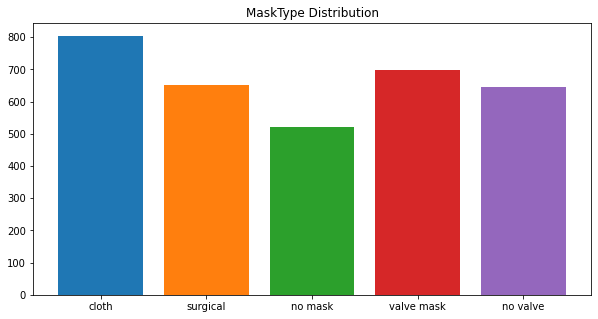

In [56]:
import pandas as pd
plt=reload(plt)

def displayDistribution(y):
  
  df = pd.DataFrame(y, columns=["labels"])
  cloth_based = df[df["labels"] == 1].shape[0]
  surgical_mask = df[df["labels"] == 2].shape[0]
  no_mask = df[df["labels"] == 3].shape[0]
  valve_mask = df[df["labels"] == 4].shape[0]
  no_valve = df[df["labels"] == 5].shape[0]

  plt.title("MaskType Distribution")
  plt.rcParams["figure.figsize"] = (10, 5)
  plt.bar("cloth", cloth_based)
  plt.bar("surgical", surgical_mask)
  plt.bar("no mask", no_mask)
  plt.bar("valve mask", valve_mask)
  plt.bar("no valve", no_valve)
  plt.plot()

displayDistribution(y)

## Visualising the Data into the Grid

In [57]:
plt=reload(plt)

def displayGrid(images, title, filter=None):
  plt.figure(figsize=(40,40)) 
  for i in range(30):
      # plt.title(y[i])
      plt.subplot(20,20,i+1)
      image = images[i]
      if filter != None:
        plt.imshow(image, cmap=filter)
      else:
          plt.imshow(image)
      plt.axis("off")
  plt.show()

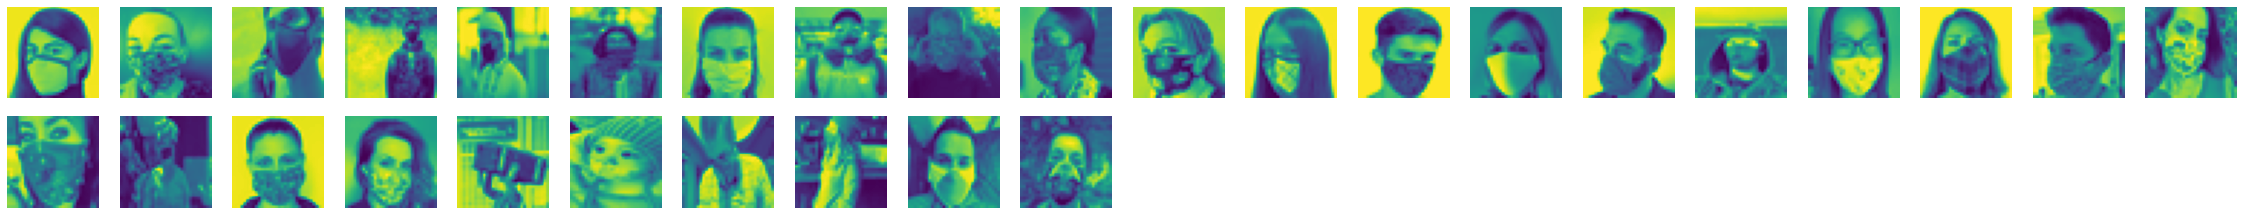

In [58]:
displayGrid(images=X, title="Training Images")

## **Training the model**




In [59]:
from skorch.helper import predefined_split

training_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = NeuralNetClassifier(
    module=LenetModel,
    train_split=predefined_split(mask_dataset),
    max_epochs=training_epochs,
    optimizer=optim.Adam,
    device=device,
    criterion=nn.CrossEntropyLoss,
    lr=1e-4,
    batch_size=128,
     callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
    ],
)


In [60]:
net.fit(mask_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.0208        2.2948       0.2422        2.2776  0.3151
      2       0.2422        2.2723       0.2422        2.2582  0.2924
      3       0.2422        2.2471       0.2422        2.2240  0.3104
      4       0.2440        2.1933       0.2519        2.1350  0.2845
      5       0.3296        2.0653       0.1880        1.9550  0.3074
      6       0.1877        1.8893       0.1898        1.7745  0.2917
      7       0.1609        1.7773       0.2697        1.6895  0.3285
      8       0.0340        1.7283       0.2151        1.6522  0.3193
      9       0.0964        1.7012       0.2115        1.6320  0.3043
     10       0.1582        1.6816       0.2118        1.6184  0.3165
     11       0.1506        1.6695       0.2136        1.6096  0.3336
     12       0.1723        1.6607       0.2157        1.6037  0.3539
     13       0.1696

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LenetModel(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (liner1): Linear(in_features=120, out_features=84, bias=True)
    (liner2): Linear(in_features=84, out_features=10, bias=True)
    (relu): ReLU()
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  ),
)

In [61]:
train_loss=[]
train_acc = []
valid_loss = []
valid_acc = []
for i in range(training_epochs):
    train_loss.append(net.history[i]['train_loss'])
    train_acc.append(net.history[i]['train_acc'])
    valid_loss.append(net.history[i]['valid_loss'])
    valid_acc.append(net.history[i]['valid_acc'])

## **Plotting the Matrix**

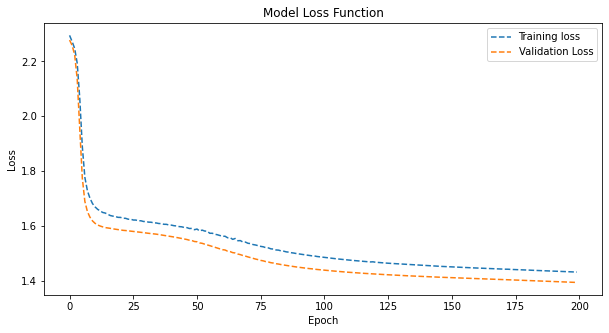

In [62]:
plt.title("Model Loss Function")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss,  '--', label="Training loss")
plt.plot(valid_loss, '--', label="Validation Loss")
plt.legend()
plt.show()

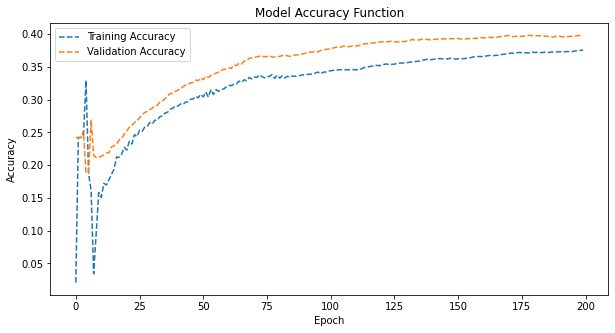

In [63]:
plt.title("Model Accuracy Function")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc,  '--', label="Training Accuracy")
plt.plot(valid_acc,  '--', label="Validation Accuracy")
plt.legend()
plt.show()


## **Model Accuracy**

In [64]:
from sklearn.metrics import accuracy_score

y_pred = net.predict(mask_test_dataset)
y_test = []
for x, y in iter(mask_test_dataset):
  y_test.append(y)

y_test = np.array(y_test)
r = accuracy_score(y_test, y_pred)
accuracy = r * 100
print("Model accuracy is {} %".format(accuracy)) 

Model accuracy is 38.01801801801802 %


## **Plotting Confusion Matrix**

In [65]:
# printing the confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[161  10  28  58  12]
 [ 74  13  21  93  17]
 [104   6  25  22  18]
 [ 18   6   0 206   3]
 [ 93  10  33  62  17]]


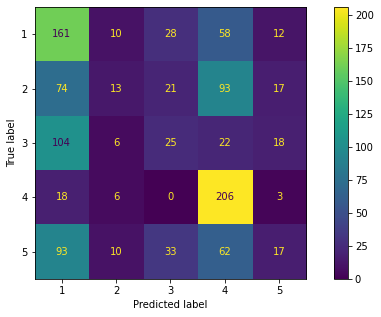

In [66]:
# plotting the confusion matrix
# NOTE: this method is perfectly working but the problem is python 3.8 version and it is working
# with scikit-learn 1.0.2 which needs to have atleast python 3.10.0
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.show()
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(net, mask_test_dataset, y_test.reshape(-1, 1))
plt.show()


In [67]:
# printing the classification report 
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3','class 4','class 5']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.36      0.60      0.45       269
     class 2       0.29      0.06      0.10       218
     class 3       0.23      0.14      0.18       175
     class 4       0.47      0.88      0.61       233
     class 5       0.25      0.08      0.12       215

    accuracy                           0.38      1110
   macro avg       0.32      0.35      0.29      1110
weighted avg       0.33      0.38      0.31      1110



## AlexNet Model Architecture

In [68]:
data = readPickleFile("", "train_256.pkl")
test_data = readPickleFile("", "test_256.pkl")
(X, y) = data

(X_test, y_test) = test_data

img_transform = transforms.Compose([transforms.ToTensor()])
mask_dataset = MaskDataSet(X, y, transform=img_transform)

mask_test_dataset = MaskDataSet(X_test, y_test, transform=img_transform)

y_cloth_train = []
for k, m in iter(mask_dataset):
  y_cloth_train.append(m)

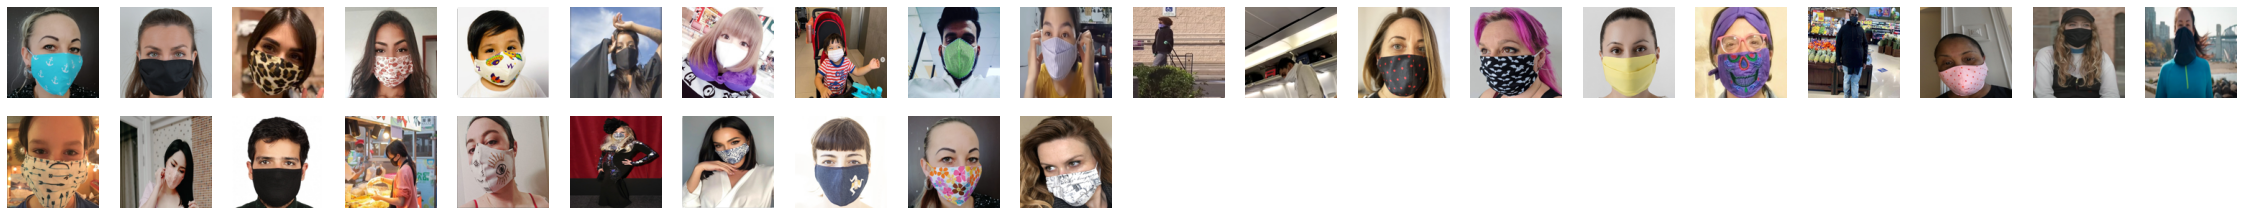

In [69]:
displayGrid(X, "AlexNet Input")

# AlexNet Architecture

<img src="./alexnet.png" alt="drawing" width="1300"/>

Photo Credits: https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

Ref Used (Important): 

1.   https://en.wikipedia.org/wiki/AlexNet
2.   https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
3. Other sources are mentioned below in the ref section




In [70]:

class AlexNetwork(nn.Module):
  def __init__(self):
    super(AlexNetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
  
    self.linear1  = nn.Linear(in_features= 9216, out_features= 4096)
    self.linear2  = nn.Linear(in_features= 4096, out_features= 4096)
    self.linear3 = nn.Linear(in_features=4096 , out_features=10)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    output = self.conv1(x)
    output = self.relu(output)
    # max pooling
    output = self.maxpool(output)
    # second conv layer.
    output = self.conv2(output)
    output = self.relu(output)

    # third convolutional layer
    output = self.conv3(output)
    output = self.relu(output)

    # fourth convolutional layer
    output = self.conv4(output)
    output = self.relu(output)

    # fifth convolutional layer
    output = self.conv5(output)
    output = self.relu(output)

    # Maxpooling layer. 
    output = self.maxpool(output)

    # Flattening layer followed by the fc network
    output = output.reshape(output.shape[0], -1)
    output = self.linear1(output)
    output = self.relu(output)

    output = self.linear2(output)
    output = self.relu(output)    

    output = self.linear3(output)
    return output

In [71]:
training_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def trainModel(optimizer, epochs=training_epochs):
    network = NeuralNetClassifier(
        module=AlexNetwork,
        max_epochs=epochs,
        train_split= predefined_split(mask_dataset),
        optimizer=optimizer,
        device=device,
        criterion=nn.CrossEntropyLoss,
        lr=1e-4,
        batch_size=128,
         callbacks=[
            EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
        ],
    )
    network.fit(mask_dataset, None)
    return network

In [72]:
adam_network = trainModel(torch.optim.Adam, 50)
sgd_network = trainModel(torch.optim.SGD, 50)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.1270        2.3226       0.2423        2.2405  1.9671
      2       0.2423        2.1981       0.2423        1.9113  1.8176
      3       0.2423        1.9085       0.1964        1.7365  1.8391
      4       0.2099        1.7325       0.2099        1.6524  1.8565
      5       0.0009        1.7397       0.1937        1.6214  1.8335
      6       0.0000        1.7148       0.2423        1.6206  1.8071
      7       0.2423        1.6726       0.2423        1.6134  1.8186
      8       0.2423        1.6578       0.2423        1.6092  1.8546
      9       0.2423        1.6508       0.2423        1.6095  1.8414
     10       0.2423        1.6514       0.2423        1.6093  1.8121
     11       0.2423        1.6527       0.2423        1.6087  1.8276
     12       0.2423        1.6514       0.2423        1.6082  1.8629
     13       0.2423

In [73]:
def metricsGenerator(network, training_epochs, train_loss, train_acc, valid_loss, valid_acc):
    net = network
    for i in range(training_epochs):
        train_loss.append(net.history[i]['train_loss'])
        valid_loss.append(net.history[i]['valid_loss'])
        valid_acc.append(net.history[i]['valid_acc'])
        train_acc.append(net.history[i]['train_acc'])

In [74]:
def plotCompareLossMetrics(model, model2, mode):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    train2_loss = []
    train2_acc = []
    valid2_loss = []
    valid2_acc = []
    metricsGenerator(model, 50, train_loss, train_acc, valid_loss, valid_acc)
    metricsGenerator(model2, 50, train2_loss, train2_acc, valid2_loss, valid2_acc)
    if mode == 'loss':
        pass
        plt.title("Loss Comparison With Different Optimisers")
        plt.ylabel("Loss Value")
        plt.xlabel("Epochs")
        plt.plot(train_loss, '--', label="Training Loss - Adam")
        plt.plot(valid_loss, '--', label="Validation Loss - Adam")
        plt.plot(train2_loss, '-', label="Training Loss - SGD")
        plt.plot(valid2_loss, '-', label="Validation Loss - SGD ")
    else:
        plt.title("Accuracy Comparison With Different Optimisers")
        plt.ylabel("Loss Value")
        plt.xlabel("Epochs")
        plt.plot(train_acc, '-', label="Training Acc - Adam")
        plt.plot(valid_acc, '-', label="Validation Acc - Adam")
        plt.plot(train2_acc, '-', label="Training Acc - SGD")
        plt.plot(valid2_acc, '-', label="Validation Acc - SGD ")
        pass
    plt.legend()
    plt.show()

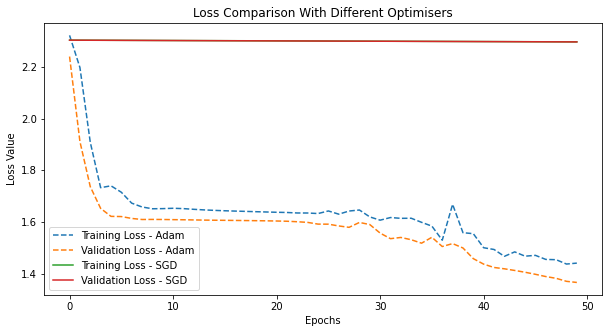

In [75]:
plotCompareLossMetrics(adam_network, sgd_network, 'loss')

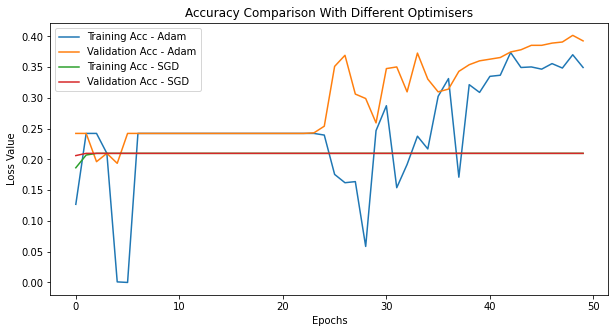

In [76]:
plotCompareLossMetrics(adam_network, sgd_network, None)

Before training the model for big iterations of the epochs, we decided to the optimal hyper-parameter, one of which is the optimiser - which is responsible for calculating the gradients and update the weights and bias in the model to minimise the cost function.

<b> Note: There are various optimisers, However, due to the time limitation we only tested on two of the most popular optimisers Adam Optimiser and SGD </b>

In the loss functional evaluation Adam optimiser performs better in the model training over the SGD optimiser. In the experiment, the Adam optimiser performed better than the SGD optimiser so we decided to opt it as the hyper-parameter for our model training

REF: Various Optimisers for model training: https://www.datarobot.com/blog/introduction-to-optimizers/

## Training the Model for Larger Epochs

In [77]:
rfromCache = input("Do you want to read model from cache Y/N: ")

net = None
if(rfromCache == "Y" or rfromCache == "y"):
    with open("./alexnet.pkl", "rb") as modelFile:
        net = pickle.load(modelFile)
else:
        net = trainModel(torch.optim.Adam)

In [78]:
# since training the Alex net model is an expensive operation, we saved it in the pickle file.
with open("alexnet.pkl", "wb") as file:
    pickle.dump(net, file)
print("Saved Alex Network trained on 200 epochs")

Saved Alex Network trained on 200 epochs


In [79]:
train_loss=[]
train_acc = []
valid_loss = []
valid_acc = []
epochs = 200
metricsGenerator(net, epochs, train_loss, train_acc, valid_loss, valid_acc)

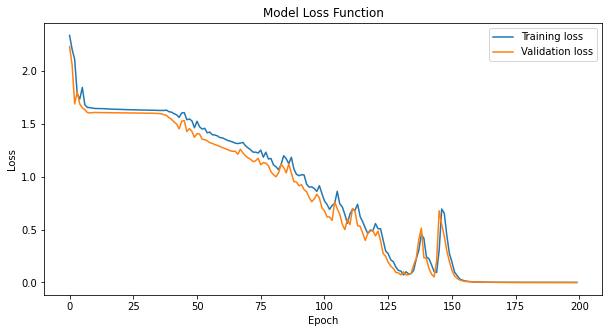

In [80]:
plt.title("Model Loss Function")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss,  '-', label="Training loss")
plt.plot(valid_loss, '-', label="Validation loss")
plt.legend()
plt.show()

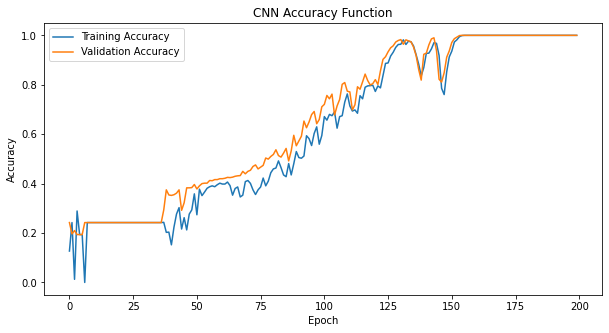

In [81]:
plt.title("CNN Accuracy Function")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_acc, '-', label="Training Accuracy")
plt.plot(valid_acc, '-', label="Validation Accuracy")
plt.legend()
plt.show()

In [82]:
y_pred = net.predict(mask_test_dataset)
y_test = []
for x, y in iter(mask_test_dataset):
  y_test.append(y)

y_test = np.array(y_test)
r = accuracy_score(y_test, y_pred)
accuracy = r * 100
print("Model accuracy is {} %".format(accuracy))

Model accuracy is 47.21301596866526 %


In [83]:
import sklearn
print(sklearn.__version__)

0.24.2


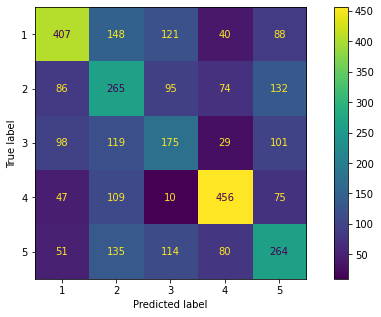

In [84]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(net, mask_test_dataset, y_test.reshape(-1, 1))
plt.show()

In [85]:
# this method is perfectly working but the problem is python 3.8 version and it is working with scikit-learn 1.0.2 which needs to have atleast python 3.10.0
# ConfusionMatrixDisplay.from_predictions(cm)

In [86]:
from sklearn.metrics import classification_report
target_names = ['Cloth Mask', 'Surgical', 'No Mask','Valve','Without Valve']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   Cloth Mask       0.59      0.51      0.55       804
     Surgical       0.34      0.41      0.37       652
      No Mask       0.34      0.34      0.34       522
        Valve       0.67      0.65      0.66       697
Without Valve       0.40      0.41      0.40       644

     accuracy                           0.47      3319
    macro avg       0.47      0.46      0.46      3319
 weighted avg       0.48      0.47      0.48      3319



## References
1.   https://towardsdatascience.com/basics-of-the-classic-cnn-a3dce1225add
2.   https://en.wikipedia.org/wiki/LeNet#:~:text=In%20general%2C%20LeNet%20refers%20to,in%20large%2Dscale%20image%20processing.
3. https://matplotlib.org/stable/tutorials/introductory/pyplot.html
4. https://medium.datadriveninvestor.com/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7
5. https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-simplest-manner-possible
6. https://github.com/skorch-dev/skorch
7. https://skorch.readthedocs.io/en/stable/user/save_load.html
8. https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
9. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
10. https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
11. https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
